### Contexte

In [1]:
import pandas as pd
import torch as torch
import numpy as np
import os
from torch import tensor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

A executer pour utiliser le GPU si disponible/compatible

In [60]:
print(torch.cuda.current_device())      
print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("CUDA available:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
print(torch.cuda.get_device_name(0))   

AssertionError: Torch not compiled with CUDA enabled

In [25]:
df =  pd.read_csv('data/WorldBankGroup_Statement_Of_Loans_and_Guarantees.csv')

C:\Users\matts\AppData\Local\Temp\ipykernel_16568\3673593615.py:1: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  df =  pd.read_csv('data/WorldBankGroup_Statement_Of_Loans_and_Guarantees.csv')


### Data Preproccesing 

On supprime les colonnes:
- `"Currency of Commitment"` vide puisqu'on sait que toutes les valeurs monétaires sont en USD
- `"Country / Economy Code"` puisqu'on a aussi une colonne avec le noms complets des pays
- `"Guarantor Country / Economy Code"` Idem
- `"Project ID"` Les identifiants des projets ne nous intéressent pas

In [26]:
df.drop(columns=["Currency of Commitment"], inplace=True)
df.drop(columns=["Country / Economy Code"], inplace=True)
df.drop(columns=["Guarantor Country / Economy Code"], inplace=True)
df.drop(columns=["Project ID"], inplace=True)

Suppression des lignes pour lesquelles on trouve des NA dans les colonnes suivantes:
- `"Interest Rate"`: Taux de NA: 2.24% (Si on ne connait pas le taux d'interet, il est difficile de faire quoi que ce soit) 

In [ ]:
df.dropna(subset=["Interest Rate"], inplace=True)

Une ligne contient une valeur `"Draft"` dans la colonne Loan Status, ce qui fausserait les résultats si conservée:

In [ ]:
df = df[df["Loan Status"] != "Draft"] 

On précise quand on ne connait pas le projet que finance le pret et on définit une catégorie `"Other"`

In [31]:
# Drop irrelevant columns
cols_to_drop = ["Loan Number", "Project Name"]  # Add more if needed
df = df.drop(columns=cols_to_drop)

KeyError: "['Loan Number', 'Project Name'] not found in axis"

----------------------------------------

In [6]:
df.shape

(1384312, 27)

In [32]:
df.sample(5)

,End of Period,Region,Country / Economy,Borrower,Guarantor,Loan Type,Loan Status,Interest Rate,Original Principal Amount (US$),Cancelled Amount (US$),...,Repaid 3rd Party (US$),Due 3rd Party (US$),Loans Held (US$),First Repayment Date,Last Repayment Date,Agreement Signing Date,Board Approval Date,Effective Date (Most Recent),Closed Date (Most Recent),Last Disbursement Date
1331064,01/31/2020,MIDDLE EAST AND NORTH AFRICA,Tunisia,Ministtry of Investments and Intl. Co-op,Tunisia,FSL,Fully Disbursed,0.00,500000000.0,0.0,...,0.0,0.0,497634433.3,09/15/2021,09/15/2049,10/02/2015,10/01/2015,12/23/2015,12/31/2016,12/30/2015
1292020,07/31/2013,EAST ASIA AND PACIFIC,Philippines,Department of Finance,Philippines,FSL,Disbursing,0.00,100000000.0,0.0,...,0.0,0.0,100000000.0,01/15/2023,07/15/2037,01/30/2013,12/11/2012,05/02/2013,12/31/2015,05/02/2013
743518,06/30/2015,EAST ASIA AND PACIFIC,China,Ministry of Finance,China,SCP USD,Repaid,6.61,290863881.7,0.0,...,0.0,0.0,0.0,12/01/1997,12/01/2011,10/28/1991,09/24/1991,01/09/1992,12/31/1998,NaN
300237,07/31/2017,AFRICA,Liberia,LIBERIA ELECTRICITY CORPORATIO,Liberia,NON POOL,Fully Repaid,7.50,10000000.0,0.0,...,0.0,0.0,0.0,10/01/1983,04/01/1998,07/07/1978,06/15/1978,12/11/1978,06/30/1982,NaN
773335,04/30/2024,LATIN AMERICA AND CARIBBEAN,"Venezuela, Republica Bolivariana de",MINISTERIO DE FINANZAS,"Venezuela, Republica Bolivariana de",SCL,Fully Repaid,5.54,19032204.6,0.0,...,0.0,0.0,0.0,04/15/1998,04/15/2007,04/05/1994,06/23/1992,06/30/1994,12/31/1999,12/14/1999


In [ ]:
df.columns

Index(['End of Period', 'Region', 'Country / Economy', 'Borrower', 'Guarantor',
       'Loan Type', 'Loan Status', 'Interest Rate',
       'Original Principal Amount (US$)', 'Cancelled Amount (US$)',
       'Undisbursed Amount (US$)', 'Disbursed Amount (US$)',
       'Repaid to IBRD (US$)', 'Due to IBRD (US$)',
       'Exchange Adjustment (US$)', 'Borrower's Obligation (US$)',
       'Sold 3rd Party (US$)', 'Repaid 3rd Party (US$)', 'Due 3rd Party (US$)',
       'Loans Held (US$)', 'First Repayment Date', 'Last Repayment Date',
       'Agreement Signing Date', 'Board Approval Date',
       'Effective Date (Most Recent)', 'Closed Date (Most Recent)',
       'Last Disbursement Date'],
      dtype='object')

In [ ]:
df.describe()

,Interest Rate,Original Principal Amount (US$),Cancelled Amount (US$),Undisbursed Amount (US$),Disbursed Amount (US$),Repaid to IBRD (US$),Due to IBRD (US$),Exchange Adjustment (US$),Borrower's Obligation (US$),Sold 3rd Party (US$),Repaid 3rd Party (US$),Due 3rd Party (US$),Loans Held (US$)
count,1.384312e+06,1.384312e+06,1.384312e+06,1.384312e+06,1.384312e+06,1.384312e+06,1.384312e+06,1.384312e+06,1.384312e+06,1.384312e+06,1.384312e+06,1384312.0,1.384312e+06
mean,4.386095e+00,8.439240e+07,1.002202e+07,7.755784e+06,6.649233e+07,4.344572e+07,2.269393e+07,-4.226992e+05,2.227123e+07,4.487509e+05,4.487509e+05,0.0,3.044971e+07
std,3.379310e+00,1.557073e+08,4.586497e+07,5.014120e+07,1.373416e+08,9.290284e+07,1.004272e+08,1.165660e+07,9.675374e+07,3.887006e+06,3.887006e+06,0.0,1.166025e+08
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.200000e-01,0.000000e+00,0.000000e+00,-1.483090e+08,-1.100785e+09,-2.600000e-01,0.000000e+00,0.000000e+00,0.0,-1.483090e+08
25%,0.000000e+00,1.207847e+07,0.000000e+00,0.000000e+00,6.985481e+06,3.119376e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00
50%,5.300000e+00,3.325320e+07,3.212700e+02,0.000000e+00,2.392313e+07,1.549080e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00
75%,7.250000e+00,9.890131e+07,3.726809e+06,0.000000e+00,7.000000e+07,4.600000e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00
max,2.825000e+01,3.750000e+09,1.995000e+09,3.379011e+09,3.153531e+09,3.000000e+09,2.923282e+09,5.065767e+08,2.842924e+09,2.499620e+08,2.499620e+08,0.0,3.750000e+09


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1384312 entries, 0 to 1416098
Data columns (total 27 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   End of Period                    1384312 non-null  object 
 1   Region                           1384312 non-null  object 
 2   Country / Economy                1384312 non-null  object 
 3   Borrower                         1374686 non-null  object 
 4   Guarantor                        1314652 non-null  object 
 5   Loan Type                        1384312 non-null  object 
 6   Loan Status                      1384312 non-null  object 
 7   Interest Rate                    1384312 non-null  float64
 8   Original Principal Amount (US$)  1384312 non-null  float64
 9   Cancelled Amount (US$)           1384312 non-null  float64
 10  Undisbursed Amount (US$)         1384312 non-null  float64
 11  Disbursed Amount (US$)           1384312 non-null  floa

In [33]:
df.columns[df.isna().any()]

Index(['Borrower', 'Guarantor', 'First Repayment Date', 'Last Repayment Date',
       'Agreement Signing Date', 'Effective Date (Most Recent)',
       'Closed Date (Most Recent)', 'Last Disbursement Date'],
      dtype='object')

In [9]:
df.groupby('Loan Status').count()

,End of Period,Region,Country / Economy,Borrower,Guarantor,Loan Type,Interest Rate,Original Principal Amount (US$),Cancelled Amount (US$),Undisbursed Amount (US$),...,Repaid 3rd Party (US$),Due 3rd Party (US$),Loans Held (US$),First Repayment Date,Last Repayment Date,Agreement Signing Date,Board Approval Date,Effective Date (Most Recent),Closed Date (Most Recent),Last Disbursement Date
Loan Status,,,,,,,,,,,,,,,,,,,,,
Approved,7314,7314,7314,7314,7252,7314,7314,7314,7314,7314,...,7314,7314,7314,7191,7191,18,7314,463,7314,0
Cancelled,12075,12075,12075,11877,10035,12075,12075,12075,12075,12075,...,12075,12075,12075,12075,12075,10800,12075,12075,11698,741
Disbursed,78540,78540,78540,78540,74610,78540,78540,78540,78540,78540,...,78540,78540,78540,78540,78540,78540,78540,78540,78540,74373
Disbursing,84491,84491,84491,84491,82696,84491,84491,84491,84491,84491,...,84491,84491,84491,84491,84491,84491,84491,84491,84491,84477
Disbursing&Repaying,14328,14328,14328,14328,14328,14328,14328,14328,14328,14328,...,14328,14328,14328,14328,14328,14328,14328,14328,14328,14325
Draft,1,1,1,0,0,1,1,1,1,1,...,1,1,1,0,0,0,0,0,1,0
Effective,3637,3637,3637,3637,3492,3637,3637,3637,3637,3637,...,3637,3637,3637,3327,3327,3637,3637,3637,3637,42
Fully Cancelled,17257,17257,17257,16948,14905,17257,17257,17257,17257,17257,...,17257,17257,17257,17257,17257,15321,17257,17164,17257,1236
Fully Disbursed,27321,27321,27321,27321,27321,27321,27321,27321,27321,27321,...,27321,27321,27321,27321,27321,27321,27321,27321,27321,27321


In [10]:
df['Loan Status'].unique()

array(['Fully Repaid', 'Repaid', 'Cancelled', 'Fully Cancelled',
       'Disbursed', 'Repaying', 'Fully Transferred', 'Disbursing',
       'Terminated', 'Disbursing&Repaying', 'Effective',
       'Fully Disbursed', 'Draft', 'Approved', 'Signed'], dtype=object)

In [34]:
nombre_classe = df['Loan Status'].value_counts().count()
print("Nombre de classes : ", nombre_classe)

Nombre de classes :  14


In [ ]:
date_cols = [col for col in df.columns if 'Date' in col or 'Period' in col]
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce').dt.year.fillna(0)

Voici le `df` finalement utilisé (réduit à 100 lignes pour soumission du moodle)

Run la commande ci-dessous génère le CSV dans le dossier data

In [68]:
df_100 = df.head(100)
df_100.to_csv('data/extrait_100.csv', index=False)

#### Data Split en train et validation 

In [36]:
target_col = "Loan Status"

In [37]:
# Encode categorical columns
categorical_cols = df.select_dtypes(include='object').columns.drop(target_col)
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

In [38]:
# Encode target separately
target_le = LabelEncoder()
df[target_col] = target_le.fit_transform(df[target_col])

In [39]:
# Normalize numerical columns
scaler = StandardScaler()
numeric_cols = df.select_dtypes(include=np.number).columns.drop(target_col)
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

In [40]:
# Features and labels
X = df[numeric_cols.union(categorical_cols)]
y = df[target_col]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Create datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

### Algo 1) reseaux de neurone

In [45]:

class LoanStatusClassifier(nn.Module):
    def __init__(self, input_size, hidden_sizes=[128, 64], num_classes=10):
        super(LoanStatusClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.output = nn.Linear(hidden_sizes[1], num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.output(x)

#### Definir l'optimiseur et entrainer les epochs

In [46]:
num_classes = len(np.unique(y_train))
model = LoanStatusClassifier(input_size=X_train.shape[1], num_classes=nombre_classe)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    train_losses = []
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        train_losses.append(total_loss)


    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}")


Epoch [1/50], Loss: 10562.1739
Epoch [2/50], Loss: 8273.3200
Epoch [3/50], Loss: 7617.8550
Epoch [4/50], Loss: 7213.9469
Epoch [5/50], Loss: 6988.6812
Epoch [6/50], Loss: 6825.9131
Epoch [7/50], Loss: 6708.3309
Epoch [8/50], Loss: 6607.2715
Epoch [9/50], Loss: 6515.1079
Epoch [10/50], Loss: 6440.4542
Epoch [11/50], Loss: 6375.1530
Epoch [12/50], Loss: 6317.7514
Epoch [13/50], Loss: 6267.8750
Epoch [14/50], Loss: 6218.5929
Epoch [15/50], Loss: 6177.5698
Epoch [16/50], Loss: 6139.3497
Epoch [17/50], Loss: 6096.3033
Epoch [18/50], Loss: 6070.3623
Epoch [19/50], Loss: 6036.5473
Epoch [20/50], Loss: 6019.9883
Epoch [21/50], Loss: 5988.8978
Epoch [22/50], Loss: 5960.0496
Epoch [23/50], Loss: 5938.3031
Epoch [24/50], Loss: 5912.0287
Epoch [25/50], Loss: 5895.4056
Epoch [26/50], Loss: 5870.3841
Epoch [27/50], Loss: 5857.1186
Epoch [28/50], Loss: 5833.4927
Epoch [29/50], Loss: 5824.4146
Epoch [30/50], Loss: 5813.8713
Epoch [31/50], Loss: 5795.5242
Epoch [32/50], Loss: 5781.7640
Epoch [33/50], L

#### Evaluer le model 

In [50]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Test Accuracy: 84.93%


#### Tracer la courbe de losss

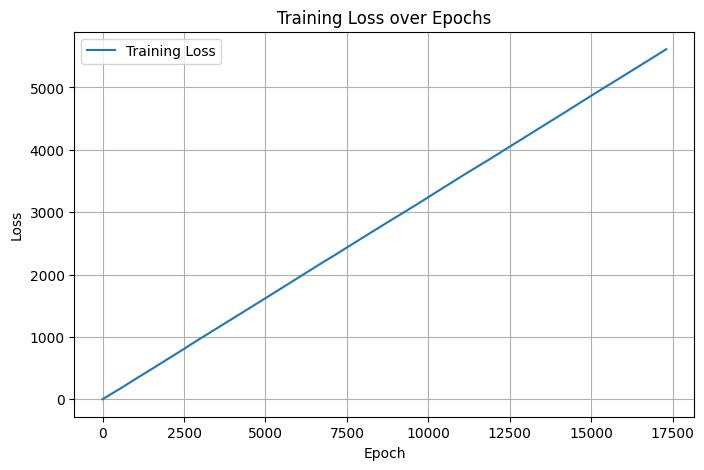

In [ ]:

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()


### Algo 2) XGBoost

In [52]:
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

# Accuracy
print(f"✅ XGBoost Accuracy: {accuracy_score(y_test, xgb_pred):.4f}")

# Classification report avec classes présentes
labels_present = unique_labels(y_test, xgb_pred)
target_names_filtered = target_le.inverse_transform(labels_present)

print("\n📊 Classification Report (XGBoost):\n")
print(classification_report(y_test, xgb_pred, labels=labels_present, target_names=target_names_filtered))


c:\Users\matts\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:34:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ XGBoost Accuracy: 0.9843

📊 Classification Report (XGBoost):

                     precision    recall  f1-score   support

           Approved       1.00      1.00      1.00      1452
          Cancelled       0.93      0.98      0.95      2424
          Disbursed       0.96      0.96      0.96     15697
         Disbursing       0.99      0.91      0.95     16975
Disbursing&Repaying       0.96      0.85      0.90      2916
          Effective       0.87      0.86      0.87       754
    Fully Cancelled       0.98      0.96      0.97      3367
    Fully Disbursed       0.86      0.98      0.92      5477
       Fully Repaid       0.99      1.00      1.00    126813
  Fully Transferred       1.00      1.00      1.00      4419
             Repaid       0.99      1.00      1.00     73153
           Repaying       0.98      0.95      0.96     20949
             Signed       0.92      0.90      0.91       958
         Terminated       1.00      1.00      1.00      1509

           accuracy

### Algo 3) LightGBM

In [53]:
lgbm_model = LGBMClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42
)

lgbm_model.fit(X_train, y_train)
lgbm_pred = lgbm_model.predict(X_test)

# Accuracy
print(f"✅ LightGBM Accuracy: {accuracy_score(y_test, lgbm_pred):.4f}")

# Classification report avec classes présentes
labels_present = unique_labels(y_test, lgbm_pred)
target_names_filtered = target_le.inverse_transform(labels_present)

print("\n📊 Classification Report (LightGBM):\n")
print(classification_report(y_test, lgbm_pred, labels=labels_present, target_names=target_names_filtered))


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,161754 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5551
[LightGBM] [Info] Number of data points in the train set: 1107448, number of used features: 25
[LightGBM] [Info] Start training from score -5,241323
[LightGBM] [Info] Start training from score -4,742752
[LightGBM] [Info] Start training from score -2,869174
[LightGBM] [Info] Start training from score -2,797449
[LightGBM] [Info] Start training from score -4,575148
[LightGBM] [Info] Start training from score -5,950982
[LightGBM] [Info] Start training from score -4,378644
[LightGBM] [Info] Start training from score -3,925887
[LightGBM] [Info] Start training from score -0,780232
[LightGBM] [Info] Start training from score -4,164265
[LightGBM] [Info] Start training from score -1,325384
[LightGBM] [Info] Start training fr

### Algo 4) Regression Logistique Multiclasse

In [54]:
class LogisticRegressionMulti(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LogisticRegressionMulti, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        return self.linear(x)  # Pas de softmax ici ! CrossEntropyLoss le fait pour nous

In [ ]:
model = LogisticRegressionMulti(input_size=X_train.shape[1], num_classes=num_classes) #.to(device) si GPU

In [63]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [65]:
num_epochs = 50
train_losses = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch #.to(device)
        y_batch = y_batch #.to(device)

        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    train_losses.append(total_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}")

Epoch [1/50], Loss: 14905.2519
Epoch [2/50], Loss: 13979.7405
Epoch [3/50], Loss: 13754.0130
Epoch [4/50], Loss: 13616.4422
Epoch [5/50], Loss: 13523.3755
Epoch [6/50], Loss: 13452.0200
Epoch [7/50], Loss: 13393.4663
Epoch [8/50], Loss: 13343.4405
Epoch [9/50], Loss: 13307.3968
Epoch [10/50], Loss: 13269.1208
Epoch [11/50], Loss: 13237.9358
Epoch [12/50], Loss: 13206.8446
Epoch [13/50], Loss: 13187.5801
Epoch [14/50], Loss: 13164.5194
Epoch [15/50], Loss: 13147.4734
Epoch [16/50], Loss: 13122.9285
Epoch [17/50], Loss: 13108.9082
Epoch [18/50], Loss: 13088.3788
Epoch [19/50], Loss: 13075.3061
Epoch [20/50], Loss: 13063.9556
Epoch [21/50], Loss: 13048.5331
Epoch [22/50], Loss: 13037.2744
Epoch [23/50], Loss: 13022.5139
Epoch [24/50], Loss: 13013.0006
Epoch [25/50], Loss: 13000.2313
Epoch [26/50], Loss: 12993.7421
Epoch [27/50], Loss: 12985.1911
Epoch [28/50], Loss: 12975.0192
Epoch [29/50], Loss: 12964.1960
Epoch [30/50], Loss: 12956.1387
Epoch [31/50], Loss: 12948.1304
Epoch [32/50], Lo

In [66]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch #.to(device)
        y_batch = y_batch #.to(device)

        outputs = model(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 63.80%


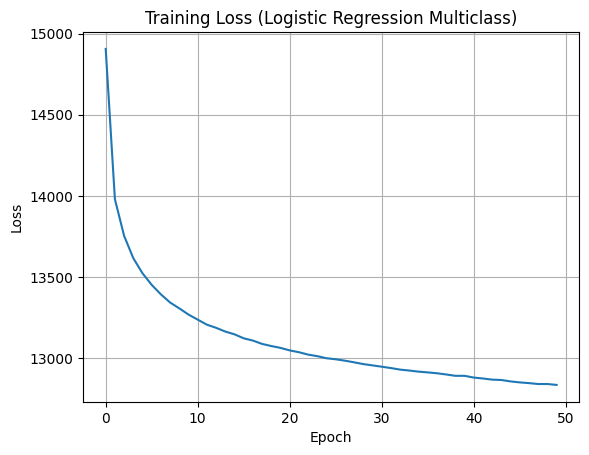

In [67]:
plt.plot(train_losses)
plt.title("Training Loss (Logistic Regression Multiclass)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

### Algo 5) Random forest 

In [41]:
rf_model = RandomForestClassifier(
    n_estimators=100,     # nombre d’arbres
    max_depth=None,       # profondeur des arbres (None = croissance max)
    random_state=42       # reproductibilité
)

rf_model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

#### Évaluer le modèle

In [42]:
y_pred = rf_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))

print(rf_model.criterion)  # Affiche 'gini' ou 'entropy'

# Identifie les classes présentes dans y_test
labels_present = unique_labels(y_test, y_pred)

# Génère les noms correspondants à ces classes
target_names_filtered = target_le.inverse_transform(labels_present)

# Classification report correct
print("\nClassification Report:\n", classification_report(
    y_test, y_pred, labels=labels_present, target_names=target_names_filtered))


Accuracy: 0.9346138703979947
gini

Classification Report:
                      precision    recall  f1-score   support

           Approved       1.00      1.00      1.00      1452
          Cancelled       0.87      0.93      0.89      2424
          Disbursed       0.94      0.95      0.94     15697
         Disbursing       0.97      0.96      0.97     16975
Disbursing&Repaying       0.99      0.96      0.98      2916
          Effective       0.94      0.92      0.93       754
    Fully Cancelled       0.95      0.90      0.92      3367
    Fully Disbursed       0.85      0.86      0.85      5477
       Fully Repaid       0.96      0.92      0.94    126813
  Fully Transferred       0.99      0.99      0.99      4419
             Repaid       0.88      0.93      0.90     73153
           Repaying       0.98      0.98      0.98     20949
             Signed       0.96      0.97      0.97       958
         Terminated       1.00      1.00      1.00      1509

           accuracy     

#### Importance des features

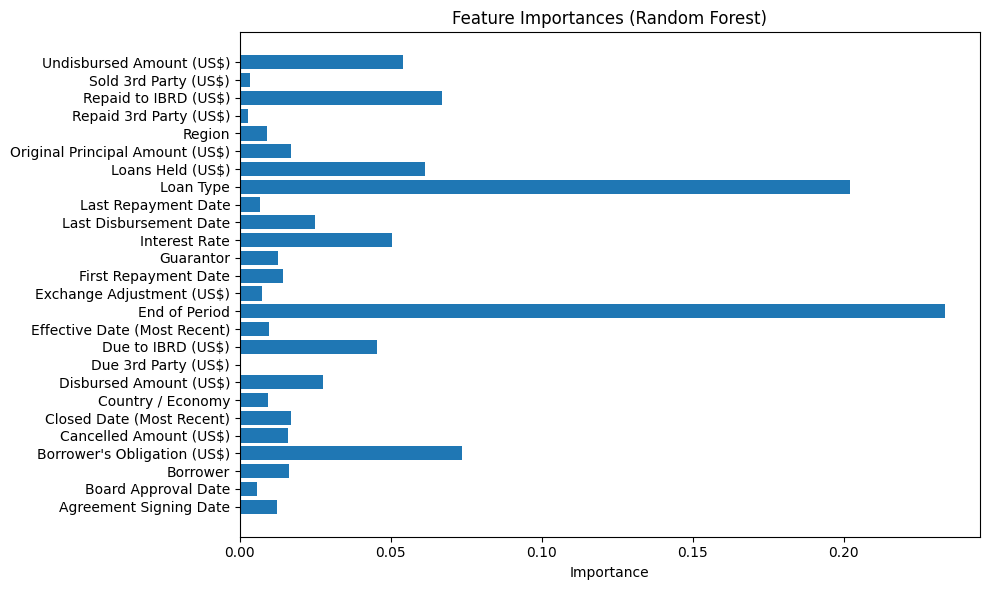

In [43]:
importances = rf_model.feature_importances_
features = X_train.columns

plt.figure(figsize=(10, 6))
plt.barh(features, importances)
plt.title("Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


#### confusion matrix

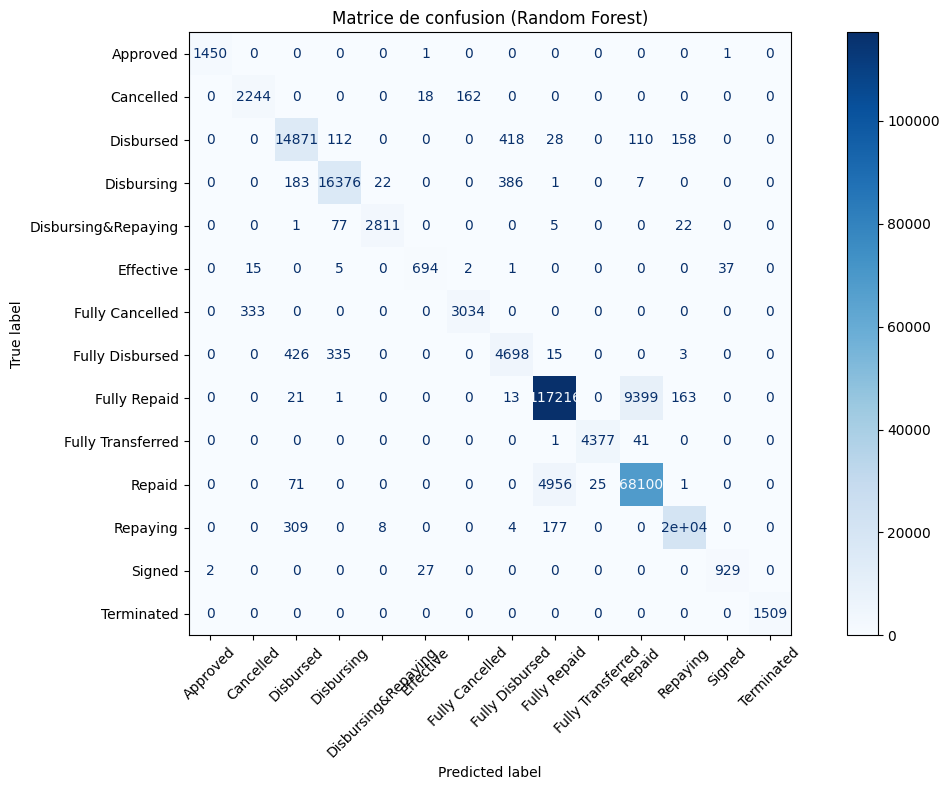

✅ Précision globale (Accuracy): 0.9346


In [44]:
# Trouve les classes réellement présentes dans y_test et y_pred
labels_present = unique_labels(y_test, y_pred)

# Génère la confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=labels_present)

# Affiche les labels correspondants
display_labels = target_le.inverse_transform(labels_present)

# Affichage
plt.figure(figsize=(12, 8))  # Ajustez la taille de la figure
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot(xticks_rotation=45, cmap="Blues", ax=plt.gca())
plt.title("Matrice de confusion (Random Forest)")
plt.tight_layout()
plt.show()

accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Précision globale (Accuracy): {accuracy:.4f}")

In [23]:
# Trouver des exemples représentatifs pour chaque classe prédite
for class_label in predicted_classes:
    class_name = target_le.inverse_transform([class_label])[0]
    examples = df[df[target_col] == class_label]['Country / Economy'].unique()[:5]  # Limité à 5 exemples
    print(f"Classe prédite: {class_name}")
    print(f"Exemples de pays: {examples}")
    print("-" * 50)

Classe prédite: Approved
Exemples de pays: [ 1.45427302 -0.39616119 -1.59894343 -1.27511744 -0.2342482 ]
--------------------------------------------------
Classe prédite: Cancelled
Exemples de pays: [ 0.41340378 -1.27511744 -0.71998718  0.8528819   1.22296875]
--------------------------------------------------
Classe prédite: Disbursed
Exemples de pays: [ 1.89375115 -0.39616119  0.66783848  0.76036019  0.87601233]
--------------------------------------------------
Classe prédite: Disbursing
Exemples de pays: [ 0.96853404 -1.59894343 -1.27511744 -1.06694359 -0.69685675]
--------------------------------------------------
Classe prédite: Disbursing&Repaying
Exemples de pays: [-1.06694359 -1.27511744  0.96853404 -0.21111777 -0.2342482 ]
--------------------------------------------------
Classe prédite: Effective
Exemples de pays: [-0.00294392 -0.69685675  0.8528819  -0.21111777  0.50592549]
--------------------------------------------------
Classe prédite: Fully Cancelled
Exemples de pays